# 第6章 学習に関するテクニック


- 確率的勾配降下法
  - SGD
  - パラメータの勾配を手がかりに最適パラメータさがしてた今までのやり方
  - 問題によってはSGDよりもいい方法がある

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        # learning rate(学習係数)
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### Momentum

Momentum: 運動量

In [3]:
import numpy as np

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


### AdaGrad

- 学習係数が小さすぎると学習に時間がかかりすぎる
- 逆に大きいと発散して正しく学習が行えない
- この学習係数に関する有効なテクニック： 学習係数の減衰(learning rate decay)
  - 初めは大きく学習 -> 次第に小さく学習

Adaは適応的のAdaptiveに由来する  

In [4]:
import numpy as np

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] = grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            # 1e-7 は0除算を防ぐためのもの
            

### Adam

直感的にはMomentumとAdaGradをあわせたもの  
ハイパーパラメータのバイアス補正が行われているのも特徴  
詳しくは原著論文  

In [5]:
# 実装は common/optimizer.py

## 重みの初期値

重みの初期値を均一にすると誤差逆伝播法で全ての重みが均一に更新されてしまうから良くない  


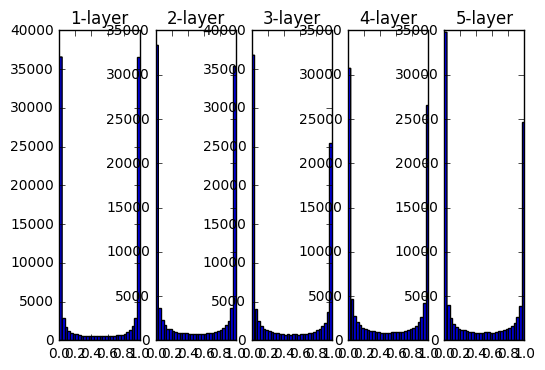

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

勾配消失: 逆伝播での勾配の値が小さくなって消えてしまうことm
    

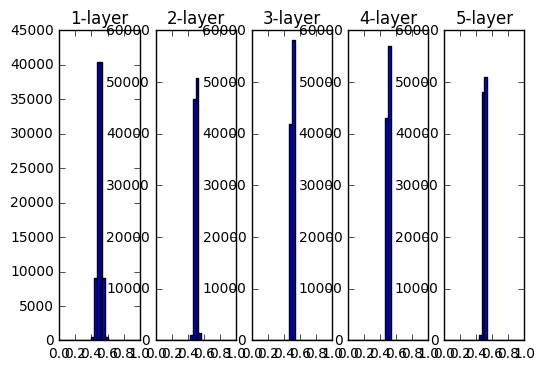

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 0.01
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

勾配消失は起きなかったが、アクティベーションに偏りができてしまった
表現力の制限（？）

Xavierの初期値  
活性化関数が線形であることを前提に導いた結果の初期値

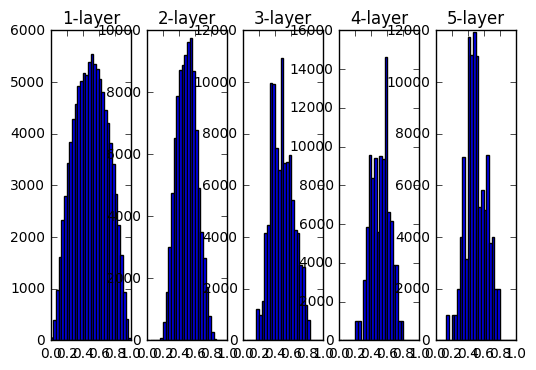

In [10]:
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

これまでよりも広がった分布になってシグモイド関数の表現力も制限されていない

ReLUに特化した初期値  
Heの初期値

### Batch Normalization

6.2では重みを適切に設定すれば角層のアクティベーションの分布は適度に広がり学習がスムーズに行えた。  
重みではなく強制的に各層で広がりを持つようにアクティベーションの分布を調整する => Batch Normalization  

データ分布の正規化を行うレイヤをニューラルネットワークに挿入する  
重みの初期値にロバスト (初期値にそれほど依存しない)  

## 過学習

主な原因

- パラメータを大量に持ち表現力の高いモデルであること
- 訓練データが少ないこと

抑制方法

Weight decay (荷重減衰)  
大きな重みを持つことに対してペナルティを化すことで過学習を抑制しようというもの  


Dropout  
ニューロンをランダムに小記しながら学習する手法  


In [1]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask


## ハイパーパラメータの検証

- e.g.
  - 各層のニューロン数
  - バッチサイズ
  - パラメータ更新時の学習係数やWeight decay
  
テストデータを使ってハイパーパラメータの性能を評価してはいけない  
テストデータを使ってハイパーパラメータの調整を行うと、ハイパーパラメータがテストデータに対して過学習を起こしてしまうから  
ハイパーパラメータを調整する際にはそれ専用の確認データが必要になる(検証データ)  
検証データを得るための最も簡単な方法： 訓練データの中から20%程度を検証データとして先に分離する  

ハイパーパラメータの範囲は大まかにざっくりと指定する  
10の階乗のスケールで  
ch06/hyperparameter_optimization.py が便利そう  

In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from common.util import shuffle_dataset

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist()
x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [5]:
import numpy as np

weigh_decay = 10 ** np.random.uniform(-8, -4)
print(weigh_decay)

lr = 10 ** np.random.uniform(-6, -2)
print(lr)

4.870638968230797e-05
0.008186470475329156


In [4]:
# P202にそれぞれのlr, weight decayで検証した結果が出てる
# 大体lr: 0.001 ~ 0.01,  weight decay10 ** -8 ~ 10 ** -6あたりが良さそう

### ここまでのまとめ

忘れてきたので  

- 3章
  - 順方向の伝播
- 4章
  - 損失関数の導入
  - 損失関数を減らすための重みパラメータの勾配を求める
  - 重みパラメータを勾配方向に微小量更新する
  - 更新回数は適当？
    - 更新回数はハイパーパラメータ
    - batch size, learning_rateもハイパーパラメータ
- 5章
  - 4章でやった部分で微分の代わりに逆誤差伝播法使うという話
- 6章
  - 重みパラメータの初期値設定
  - ハイパーパラメータの設定方法
  - 過学習の対応策
